* Name: `dissipation-theory--Study-11.ipynb`
* Author: John A. Marohn
* Date: 2023-11-14
* Continued from: `dissipation-theory--Study-10.ipynb`
* Continued from: `2023-10-03--jam99--20230808-ringdown-NiOx-U551--Study-1.ipynb`
* Continued to: ---
* Summary: Calculate dissipation versus height over a sample with properties similar to Rachael's PM6:Y6 and compare to Marohn's analytical expression derived in the thick-sample limit.

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [3]:
from dissipationtheory.constants import epsilon0
from dissipationtheory.capacitance import Csphere

In [4]:
THIS = 'dissipation-theory--Study-11'

# Numerical computation using Lekkala and Loring's theory

Following the computation in `dissipation-theory--Study-10.ipynb`, consider a semiconductor sample with

* thickness $h_{\mathrm{s}} = 110 \: \mathrm{nm}$
* complex relative dielectric constant $\epsilon_{\mathrm{s}} = 3.4 - 0. j$
* charge density $\rho = 1 \times 10^{24} \: \mathrm{m}^{-3}$
* charge mobility $\mu = 10^{-4} \: \mathrm{cm}^2 \: \mathrm{V}^{-1} \mathrm{s}^{-1}$
  
and a cantilever with

* resonance frequency $f_{\mathrm{c}} = 75 \: \mathrm{kHz}$
* tip voltage $V_{\mathrm{ts}} = 1 \: \mathrm{V}$
* radius $r = 30 \: \mathrm{nm}$
* tip-sample separation $h = 120 \: \mathrm{nm}$

The semiconductor is backed by a metal, which we will model as a dielectric with relative dielectric constant $\epsilon_{\mathrm{d}} = 10^{6}$.   

Use Lekkala and Loring's `Model 1` to compute the perpendicular friction $\gamma_{\perp}$ versus charge density $\rho$.  Plot $\gamma_{\perp}$ *vs.* $\rho$ and then versus conductivity $\sigma = e \mu \rho$.

In [5]:
hs = ureg.Quantity(110, 'nanometer')   # measured
epsilons = complex(3.4, 0.)            # reasonable guess
rho = ureg.Quantity(1e24,'m^{-3}')     # wild guess
mu = ureg.Quantity(1e-4, 'cm^2/(s V)') # representative number

fc = ureg.Quantity(75, 'kHz')       # measured
Vts = ureg.Quantity(1, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
h = ureg.Quantity(120, 'nanometer') # measured

Print out the charge density in various units.

In [6]:
print('charge density = {:+.2e~P}'.format(rho.to('cm^{-3}')))
print('charge density = {:+.2e~P}'.format(rho.to('m^{-3}')))

charge density = +1.00e+18 1/cm³
charge density = +1.00e+24 1/m³


Compute the associated coductivity and print it out in the same units as in Rachael's draft paper.

In [7]:
sigma = (qe * mu * rho).to('S/m')

In [8]:
print('conductivity = {:+.2f~P}'.format(sigma.to('mS/m')))

conductivity = +1.60 mS/m


Now set up the simulation.

In [9]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        h.to('m').magnitude), 
    epsilon_s=epsilons,
    h_s=hs.to('m').magnitude,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=rho.to('m^{-3}').magnitude,
    epsilon_d=complex(1.0e6, 0.),
    z_r=h.to('m').magnitude)

Do a first simulation of friction versus charge density.

In [10]:
rho_= ureg.Quantity(np.logspace(start=17, stop=27, num=50), '1/m^3')
sigma_ = (qe * mu * rho_).to('1/(ohm m)')

In [11]:
%%time
result1 = {
    'rho': rho_,
    'sigma': sigma_,
    'gamma': ureg.Quantity(np.zeros_like(rho_), 'pN s/m')
}

for index, rho__ in enumerate(rho_):

        sample1_jit.rho = rho__.to('1/m^3').magnitude
        result1['gamma'][index] = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')

CPU times: user 474 ms, sys: 11.8 ms, total: 486 ms
Wall time: 516 ms


Plot the computed friction versus charge density.

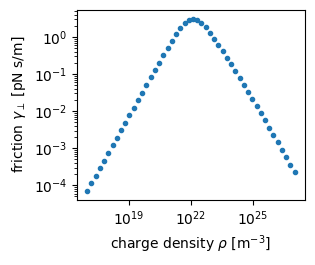

In [12]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1a.png', dpi=300)
plt.savefig(THIS + '--Fig-1a.pdf')

plt.show()

The estimated charge density of $10^{24} \: \mathrm{m}^{-3}$ is *above* the friction maximum, beyond the low-density limit.  Uh-oh.

# Analytical computation using Dwyer's model (first pass)

Make an array of sample heights that is just one element long.  Do this because the function `Cphere` expects an array of heights.

In [13]:
h_ = ureg.Quantity(np.array([h.to('m').magnitude]), 'm') 
c0 = Csphere(0, height=h_, radius=r, nterm=21)
c1 = Csphere(1, height=h_, radius=r, nterm=21)

In [14]:
(c0, c1)

(array([3.70925067e-18]) <Unit('coulomb / volt')>,
 array([-2.75910095e-12]) <Unit('coulomb / meter / volt')>)

Introduce the height to the center of the tip charge, $d = h + r$.  Compute the resistance and capacitance proportionality constants.

In [15]:
d = h + r
kR = ( (2 * np.pi * c1**2) / (c0**2/(2 * d**3) - c0*c1/(d**2) + c1**2/d)).to('m')
kC = (kR - c0/(epsilon0 * epsilons.real)).to('m')

In [16]:
(kR, kC)

(array([1.88024273e-08]) <Unit('meter')>,
 array([-1.04411142e-07]) <Unit('meter')>)

Why is $k_{\mathrm{C}}$ *negative*?  This seems unphysical.

In [17]:
Rs = 1/(sigma_ * kR)
Cs = epsilon0 * epsilons.real * kC

In [18]:
(Rs, Cs)

(array([3.31952306e+17, 2.07488512e+17, 1.29691772e+17, 8.10645155e+16,
        5.06697963e+16, 3.16714193e+16, 1.97963851e+16, 1.23738333e+16,
        7.73432875e+15, 4.83438235e+15, 3.02175579e+15, 1.88876415e+15,
        1.18058184e+15, 7.37928808e+14, 4.61246233e+14, 2.88304353e+14,
        1.80206133e+14, 1.12638779e+14, 7.04054537e+13, 4.40072944e+13,
        2.75069879e+13, 1.71933856e+13, 1.07468150e+13, 6.71735249e+12,
        4.19871605e+12, 2.62442927e+12, 1.64041314e+12, 1.02534875e+12,
        6.40899562e+11, 4.00597599e+11, 2.50395610e+11, 1.56511076e+11,
        9.78280607e+10, 6.11479373e+10, 3.82208357e+10, 2.38901318e+10,
        1.49326510e+10, 9.33373102e+09, 5.83409704e+09, 3.64663265e+09,
        2.27934667e+09, 1.42471747e+09, 8.90527054e+08, 5.56628559e+08,
        3.47923571e+08, 2.17471435e+08, 1.35931650e+08, 8.49647834e+07,
        5.31076791e+07, 3.31952306e+07]) <Unit('ohm')>,
 array([-3.14321791e-18]) <Unit('coulomb / volt')>)

Why is $C_{\mathrm{s}}$ *negative*?  Again, unphysical.  Proceed anyway.

In [19]:
result1['gamma Dwyer'] = ((c1**2 * Vts**2 * Rs) / (1 + (2 * np.pi * fc)**2 * Rs**2 * (c0 + Cs)**2)).to('pN s/m')

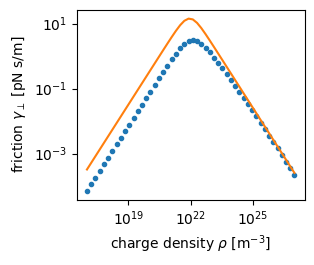

In [20]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma Dwyer'].to('pN s/m').magnitude,
    '-')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1b.png', dpi=300)
plt.savefig(THIS + '--Fig-1b.pdf')

plt.show()

In spite of $C_{\mathrm{s}}$ being negative, my ansatz for $C_{\mathrm{s}}$ and $R_{\mathrm{s}}$ predicts the correct friction in the high-density limit.  Surprisingly, the ansatz does less well in the low-density limit, the limiting case the ansatz was initially developed for. 

**Conclusion**.  Revisit my paper-and-pencil ansats for $C_{\mathrm{s}}$ and $R_{\mathrm{s}}$.  Why is $C_{\mathrm{s}}$ coming out negative?